In [ ]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

%tensorflow_version 2.x
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteYHDL9Y/imdb_reviews-train.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteYHDL9Y/imdb_reviews-test.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteYHDL9Y/imdb_reviews-unsupervised.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
train_dataset.cardinality()

<tf.Tensor: shape=(), dtype=int64, numpy=25000>

In [ ]:
np.unique(np.vstack(list(tfds.as_numpy(test_dataset)))[:,1].astype(int))

array([0, 1])

In [ ]:
help(train_dataset)

Help on PrefetchDataset in module tensorflow.python.data.ops.dataset_ops object:

class PrefetchDataset(UnaryUnchangedStructureDataset)
 |  PrefetchDataset(input_dataset, buffer_size, slack_period=None, name=None)
 |  
 |  A `Dataset` that asynchronously prefetches its input.
 |  
 |  Method resolution order:
 |      PrefetchDataset
 |      UnaryUnchangedStructureDataset
 |      UnaryDataset
 |      DatasetV2
 |      collections.abc.Iterable
 |      tensorflow.python.training.tracking.base.Trackable
 |      tensorflow.python.framework.composite_tensor.CompositeTensor
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, input_dataset, buffer_size, slack_period=None, name=None)
 |      See `Dataset.prefetch()` for details.
 |  
 |  ----------------------------------------------------------------------
 |  Data and other attributes defined here:
 |  
 |  __abstractmethods__ = frozenset()
 |  
 |  -------------------------------------------------------------------

In [ ]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [ ]:
BATCH_SIZE = 64

train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [ ]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([11, 14, 34])

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    # tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 64)          64000     
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 130,177
Trainable params: 130,177
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=10)

Epoch 1/10
391/391 [==============================] - 45s 85ms/step - loss: 0.6560 - accuracy: 0.5567 - val_loss: 0.5547 - val_accuracy: 0.7125
Epoch 2/10
391/391 [==============================] - 31s 79ms/step - loss: 0.5028 - accuracy: 0.7407 - val_loss: 0.5405 - val_accuracy: 0.6812
Epoch 3/10
391/391 [==============================] - 31s 79ms/step - loss: 0.4951 - accuracy: 0.7696 - val_loss: 0.5051 - val_accuracy: 0.7766
Epoch 4/10
391/391 [==============================] - 31s 79ms/step - loss: 0.4906 - accuracy: 0.7976 - val_loss: 0.4684 - val_accuracy: 0.8016
Epoch 5/10
391/391 [==============================] - 31s 79ms/step - loss: 0.4124 - accuracy: 0.8320 - val_loss: 0.4443 - val_accuracy: 0.8188
Epoch 6/10
391/391 [==============================] - 31s 79ms/step - loss: 0.3824 - accuracy: 0.8406 - val_loss: 0.4304 - val_accuracy: 0.8234
Epoch 7/10
391/391 [==============================] - 31s 79ms/step - loss: 0.3611 - accuracy: 0.8449 - val_loss: 0.4048 - val_accuracy:

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 18s 46ms/step - loss: 0.3610 - accuracy: 0.8513
Test Loss: 0.36102554202079773
Test Accuracy: 0.8512799739837646


In [ ]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})

def plot_metric(history, metric):
  plt.plot(history.history[metric], linewidth=4)
  plt.plot(history.history['val_'+metric], linewidth=4)
  plt.xlabel("Épocas")
  plt.legend(['Treino', 'Teste'])

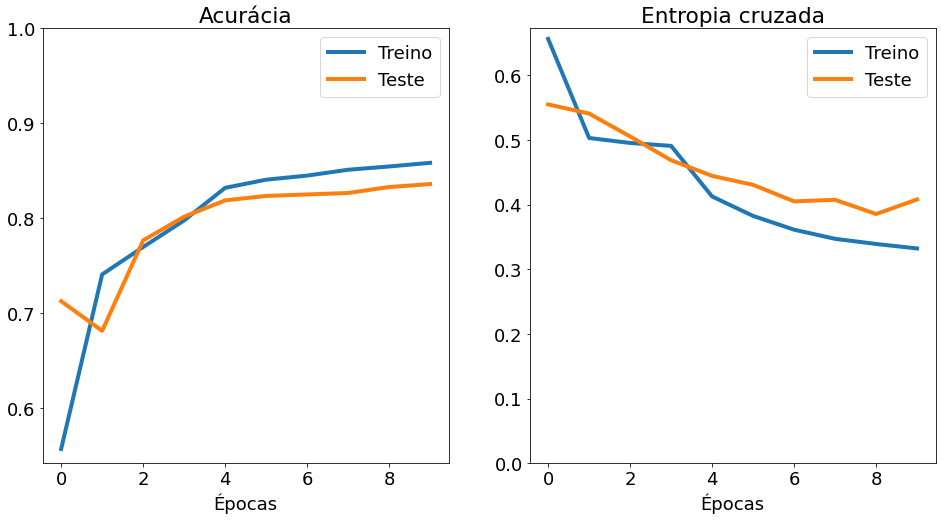

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.title("Acurácia")
plot_metric(history, 'accuracy')
# plt.ylabel("Acurácia")
plt.ylim(None, 1)

plt.subplot(1, 2, 2)
plt.title("Entropia cruzada")
plot_metric(history, 'loss')
# plt.ylabel("Entropia Cruzada")
plt.ylim(0, None)

plt.savefig("text-classification-baseline.pdf", format="pdf", bbox_inches="tight")
plt.show();

In [ ]:
improved_model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

improved_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

improved_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding_2 (Embedding)     (None, None, 64)          64000     
                                                                 
 bidirectional_2 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 138,369
Trainable params: 138,369
Non-tr

In [ ]:
history_improved = improved_model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=10)

Epoch 1/10
391/391 [==============================] - 43s 90ms/step - loss: 0.6441 - accuracy: 0.5782 - val_loss: 0.5240 - val_accuracy: 0.7078
Epoch 2/10
391/391 [==============================] - 32s 81ms/step - loss: 0.4200 - accuracy: 0.8051 - val_loss: 0.3976 - val_accuracy: 0.8313
Epoch 3/10
391/391 [==============================] - 36s 93ms/step - loss: 0.3459 - accuracy: 0.8475 - val_loss: 0.3772 - val_accuracy: 0.8438
Epoch 4/10
391/391 [==============================] - 32s 82ms/step - loss: 0.3269 - accuracy: 0.8581 - val_loss: 0.3728 - val_accuracy: 0.8422
Epoch 5/10
391/391 [==============================] - 31s 80ms/step - loss: 0.3178 - accuracy: 0.8635 - val_loss: 0.3718 - val_accuracy: 0.8422
Epoch 6/10
391/391 [==============================] - 32s 82ms/step - loss: 0.3141 - accuracy: 0.8659 - val_loss: 0.3712 - val_accuracy: 0.8438
Epoch 7/10
391/391 [==============================] - 31s 80ms/step - loss: 0.3114 - accuracy: 0.8674 - val_loss: 0.3681 - val_accuracy:

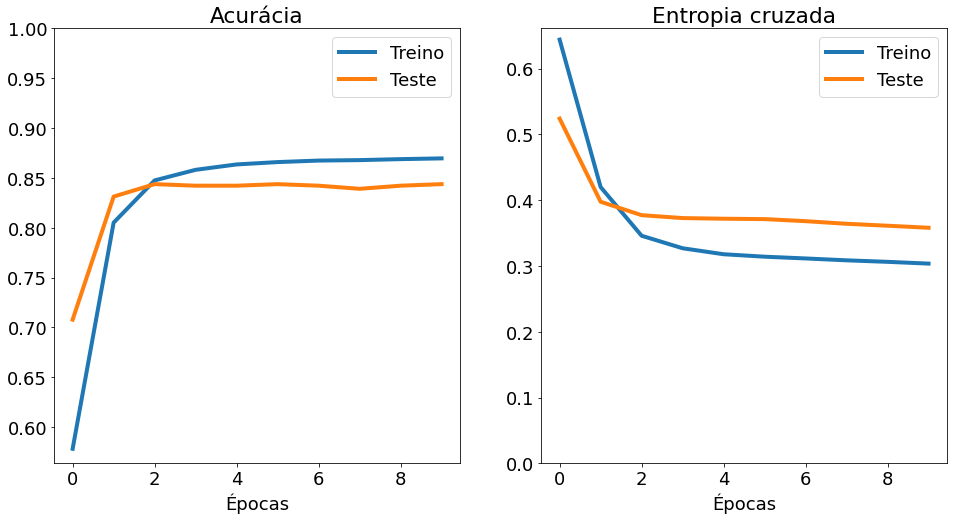

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.title("Acurácia")
plot_metric(history_improved, 'accuracy')
# plt.ylabel("Acurácia")
plt.ylim(None, 1)

plt.subplot(1, 2, 2)
plt.title("Entropia cruzada")
plot_metric(history_improved, 'loss')
# plt.ylabel("Entropia Cruzada")
plt.ylim(0, None)

plt.savefig("text-classification-improved.pdf", format="pdf", bbox_inches="tight")
plt.show();

In [ ]:
improved_model2 = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

improved_model2.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

improved_model2.summary()

history_improved2 = improved_model2.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=10)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding_6 (Embedding)     (None, None, 64)          64000     
                                                                 
 bidirectional_5 (Bidirectio  (None, None, 128)        66048     
 nal)                                                            
                                                                 
 bidirectional_6 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                      

In [ ]:
test_loss, test_acc = improved_model2.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 34s 86ms/step - loss: 0.3344 - accuracy: 0.8624
Test Loss: 0.33444446325302124
Test Accuracy: 0.8624399900436401


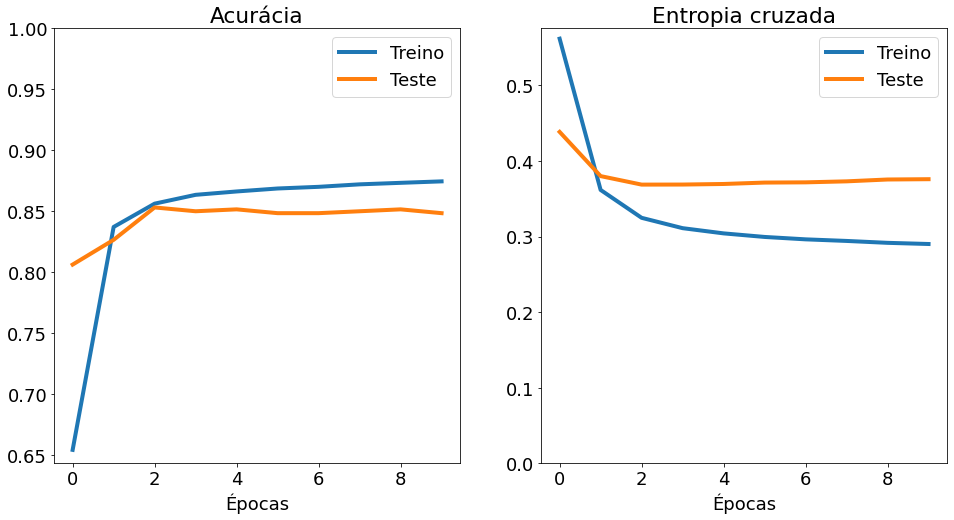

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.title("Acurácia")
plot_metric(history_improved2, 'accuracy')
# plt.ylabel("Acurácia")
plt.ylim(None, 1)

plt.subplot(1, 2, 2)
plt.title("Entropia cruzada")
plot_metric(history_improved2, 'loss')
# plt.ylabel("Entropia Cruzada")
plt.ylim(0, None)

plt.savefig("text-classification-improved2.pdf", format="pdf", bbox_inches="tight")
plt.show();